In [2]:
'''
Initializes python packages and give paths to appropriate files to be used like categories file,
the twitter file to be used alongwith the default stopword list (This is where our own created stoplist will be declared too).
'''
from __future__ import print_function
from IPython.display import display
import datetime, calendar, nltk, string, math, csv, glob, ntpath, os.path, 
import numpy as np
from gensim.models import Phrases
from collections import defaultdict
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer; wnl = WordNetLemmatizer()
import warnings, matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
#from rirdc_lib_old import cleanUp, calculate_seed
import pyLDAvis, pyLDAvis.sklearn; pyLDAvis.enable_notebook()
from sklearn.cluster import KMeans
import matplotlib.image as mpimg
import pandas as pd

path = r'C:\Users\shilp\Documents' 
stopwords_file, categories_file = path+'\\stopwords.txt', path+'\\Category_DomainTerms.txt' # {(category, term)}
out_fname= path+'\\new_data_file.csv'
extra_cats_file=path+'\\extra_cats.txt'
n_topics, seed_ratio = 5, 0.25
max_df, min_df = 0.5, 0.1 # For the VSM
topic_groups=[]
#from rirdc_lib_old import cleanUp, calculate_seed
def keywithmaxval(d):
    v=list(d.values());k=list(d.keys())
    return k[v.index(max(v))]
value=int(input("1 for twitter and 2 for patents"))
if value==1:
    data_file=path+'\\results-20170725-145833.csv'
elif value==2:
    data_file=path+'\\urlpatentout2017_1.csv'
print('Loading packages and file paths declarations done...')

1 for twitter and 2 for patents1
Loading packages and file paths declarations done...


In [3]:
#Creates a new file from the tweet file by getting rid of rows that are incomplete by appending their content to the 
#preceding row and deleting blank rows
test_file=open(data_file,encoding="ISO-8859-1")
twitter_file = open(out_fname, 'w',encoding="ISO-8859-1",newline='')
reader = csv.reader(test_file, delimiter=',')
writer = csv.writer(twitter_file)
next(reader, None)
prev=reader
for row in reader:
    if row[0] in (None, ""):
        continue
    for term in row[3]:
        if term.isalpha()==False:
            try:
                if math.isnan(float(term)):
                    print("Entered")
                    row[3]=row[3].replace(term,' ')
            except:
                    pass
        if ord(term) > 127:
            row[3]=row[3].replace(term,' ')
        wnl.lemmatize(term,'n')
    writer.writerow(row)
test_file.close()
twitter_file.close()
print('Done Creating the cleaned version of tweet file...')

Done Creating the cleaned version of tweet file...


In [4]:
# Loading the Wordnet domains.
s2d = []
for i in open('C:\\nltk_data\\corpora\\wn-domains-3.2\\wn-domains-3.2-20070223', 'r'):
    ssid, doms = i.strip().split('\t')
    doms = doms.split()
    for d in doms:
        s2d.append(d)
synset2domains=list(set(s2d))
extra_cats={}

for syn in synset2domains:
    try:
        p_list,c_list,categories=[],[],[]
        obj=wn.synset(syn+'.n.01')
        topics=obj.topic_domains()
        parents=obj.hypernyms()
        children=obj.hyponyms()
        domains= [ topic.lemma_names() for topic in topics ] 
        for sublist in domains:
            for item in sublist:
                    categories.append(str(item.replace('_',' ')))
        pwords = [ parent.lemma_names() for parent in parents ]
        for sublist in pwords:
            for item in sublist:
                    p_list.append(str(item.replace('_',' ')))
        cwords = [ child.lemma_names() for child in children]
        for sublist in cwords:
            for item in sublist:
                    c_list.append(str(item.replace('_',' ')))
        words=p_list+c_list
        if categories:
            for category in categories:
                extra_cats[category]=words
    except:
        pass

out_extra_cats = open(extra_cats_file, 'w')
for k in extra_cats.keys():
    for v in extra_cats[k]:
        out_extra_cats.write(k+", ")
        out_extra_cats.write(v+"\n")
out_extra_cats.close()
print("Done creating extra categories..")

Done creating extra categories..


In [5]:
#Creates the equal number of files for the unique months and locations present 
#in the data file and dumps corresponding tweets to the appropriate ones.

input_file = open(out_fname,encoding="ISO-8859-1")
date_list,country_list=[],[]
reader = csv.reader(input_file, delimiter=',')

#Creates a unique list of months and countries from tweets
for row in reader:
    created_at,*rest=row[1].split(' ')           #splits the 'Created at' column to retrieve 'month'
    year,months,date=created_at.split('-')
    month=calendar.month_name[int(months)]
    if month not in date_list:
       date_list.append(str(month))
    if row[6] not in country_list:
       country_list.append(str(row[6]))

#Creates csv files with names after months
for month in date_list:
   outfile = open(path+'\Data{0:2s}'.format(str(month))+'.csv', 'w', newline='',encoding="ISO-8859-1")
   writer = csv.writer(outfile, delimiter = ',')
   writer.writerow(["tweet_id","month","text","country"])
   outfile.close()
 
#Creates csv files with names after countries
for country in country_list:
   outfile = open(path+'\Data{0:2s}'.format(str(country))+'.csv', 'w', newline='',encoding="ISO-8859-1")
   writer = csv.writer(outfile, delimiter = ',')
   writer.writerow(["tweet_id","month","text","country"])
   outfile.close()
    
#Shifts rows of tweets to their respective csv files  -->  For Months
for month1 in date_list:
  with open(out_fname, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(month1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        created_at,*rest=row[1].split(' ')  
        year,months,date=created_at.split('-')
        month2=calendar.month_name[int(months)]
        if month1==month2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()
 
#Shifts rows of tweets to their respective csv files  -->  For Countries
for country1 in country_list:
  with open(out_fname, 'r',encoding="ISO-8859-1") as f:
    reader = csv.reader(f, delimiter=',')
    outfile = open(path+'\Data{0:2s}'.format(str(country1))+'.csv','a', newline='',encoding="ISO-8859-1")
    for row in reader:
        if row[0] in (None, ""):
          continue
        country2=str(row[6])
        if country1==country2:
            writer = csv.writer(outfile, delimiter =',')
            writer.writerow(row)
    outfile.close()
print('Done moving tweets to their respective months and location files...')

Done moving tweets to their respective months and location files...


In [6]:
#Tokenizes and remove stopwords from the tweet column of the data file for bigrams and unigrams --> For Months

df=open(stopwords_file,"r",encoding="ISO-8859-1", errors='replace')
stops=df.readlines(); df.close()
stops = set([word.strip() for word in stops])                  #stores stopwords tokens from the stoplist in a list
stops1=list(stops)
stops2=''.join(stops1)
tweet_id_m, text_m={},{}
tweet_id_c,text_c={},{}
docs,r=[],[]
sentences=[]
DocZ_m, DocZ_c, DocZ_m_wob, DocZ_c_wob = {},{},{},{} # will be used to find categories
for month in date_list:
    u,p,d,d_wob=[],[],[],[]
    outfile = open(r'C:\Users\shilp\Documents\Data{0:2s}'.format(str(month))+'.csv', 'r', newline='',encoding="ISO-8859-1")
    reader = csv.reader(outfile, delimiter=',')
    next(reader,None)
    docs=list(reader);
    for doc in docs:    
        tmp = [t.strip() for t in doc]
        try:
            if len(tmp[3])>0: # Making sure not blanks
                sentence = [word
                    for word in nltk.word_tokenize(tmp[3].lower())
                    if word not in string.punctuation
                           and len(word)>3
                           ]
                filtered_word_list = sentence[:] #make a copy of the word_list
                for term in sentence: # iterate over word_list
                    if term in stops2: 
                        filtered_word_list.remove(term)
                d_wob.append(tmp[3].lower())                  #Unigrams List
                sentences.append(filtered_word_list)                  #Bigrams List
                filtered=' '.join(filtered_word_list)
                u.append(tmp[0]); p.append(tmp[3]);d.append(filtered)
        except:
            pass
    tweet_id_m[month]=u
    text_m[month]=p 
    DocZ_m[month]=d
    DocZ_m_wob[month]=d_wob
   
print("For the months found")
#print("The bigrams are -->", DocZ_m)
#print("The unigrams are -->", DocZ_m_wob)

#Gets the top five bigrams
flat_list = [item for sublist in sentences for item in sublist]
word_counter = {}
for word in flat_list:
     if word in word_counter:
        word_counter[word] += 1
     else:
         word_counter[word] = 1
popular_words = sorted(word_counter, key = word_counter.get, reverse = True)
top_5 = popular_words[:5]
print("The top five bigrams are",top_5)
del u,p,d,d_wob,sentence
    
del docs
print("Clean-up for months done...,", end = ' ', flush = True)  

For the months found
The top five bigrams are ['just', 'love', 'today', 'good', 'people']
Clean-up for months done..., 

In [7]:
'''
#Tokenizes and remove stopwords from the tweet column of the data file for bigrams and unigrams --> For Countries
for country in country_list:
    u,p,d,d_wob=[],[],[],[]
    outfile = open(r'C:\Users\shilp\Documents\Data{0:2s}'.format(str(country))+'.csv', 'r', newline='',encoding="ISO-8859-1")
    reader = csv.reader(outfile, delimiter=',')
    next(reader,None)
    docs=list(reader);
    for doc in docs:    
       tmp = [t.strip() for t in doc]
       try:
         if len(tmp[3])>7: # Making sure not blanks
            sentence = [word
                    for word in nltk.word_tokenize(tmp[3].lower())
                    if word not in string.punctuation
                        and len(word)>3]
            filtered_word_list = sentence[:] #make a copy of the word_list
            for term in sentence: # iterate over word_list
                    if term in stops2: 
                        filtered_word_list.remove(term)
            d_wob.append(tmp[3].lower())
            filtered=' '.join(filtered_word_list)
            u.append(tmp[0]); p.append(tmp[3]);d.append(filtered)
       except:
           pass
    tweet_id_c[country]=u
    text_c[country]=p  #make phrase
    DocZ_c[country]=d
    DocZ_c_wob[country]=d_wob
    
print("For the countries found")
print("The bigrams are -->", DocZ_c)
print("The unigrams are -->", DocZ_c_wob)
    
print("Clean-up for countries done...,", end = ' ', flush = True)
'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 195-196: truncated \UXXXXXXXX escape (<ipython-input-7-2e4a3d555084>, line 36)

In [8]:
# Loading categories into category dictionary of set of terms for bigrams and unigrams for months

print("Please wait (it's going to take a while): Loading Data,", end = ' ', flush = True)
df=open(categories_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); categories = {}
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])               #stores categories-terms as a key-value in a dictionary from the file
del cats,df

df=open(extra_cats_file,"r",encoding="ISO-8859-1", errors='replace')
cats=df.readlines(); df.close(); 
for cat in cats:
     key = cat.split(', ')[0].strip(); term = cat.split(', ')[1].strip().lower()
     try:        
          categories[key].add(term)
     except:
          categories[key] = set([term])   
print("pre-Categories mapping ... ", flush = True)    
doc_cats_m,doc_cat_m = {}, {}; del cats, df
doc_cats_m_wob,doc_cat_m_wob={},{};
for month in date_list:
   doc_cats_m[month],doc_cat_m[month]={},{} 
   for idx, doc in enumerate(DocZ_m[month]):
       notInCategories,total=[],0
       doc_cats_m[month][idx]={}
       for cat, terms in categories.items():
          for term in terms:
             n = doc.count(term)              #calculates the frequency of occurance of terms corresponding to terms for the category
             total+=n
             try:
                doc_cats_m[month][idx][cat] += n
             except:
                doc_cats_m[month][idx][cat]= n
       for cat, terms in categories.items():
            if total==0:
               doc_cat_m[month][idx] = None
               doc_cats_m[month][idx][cat] = 0.0
               if month not in notInCategories:
                  notInCategories.append(month)
            else:
             doc_cat_m[month][idx] = keywithmaxval(doc_cats_m[month][idx])           # category of doc[idx]
             doc_cats_m[month][idx][cat] = doc_cats_m[month][idx][cat]/total          # Normalizing to category's ratio
                
del doc
#print(doc_cat_m)
print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(DocZ_m)), flush = True)

#For unigrams
for month in date_list:
   doc_cats_m_wob[month],doc_cat_m_wob[month]={},{} 
   for idx, doc in enumerate(DocZ_m_wob[month]):
       notInCategories,total=[],0
       doc_cats_m_wob[month][idx]={}
       for cat, terms in categories.items():
          for term in terms:
             n = doc.count(term)
             total+=n
             try:
                doc_cats_m_wob[month][idx][cat] += n
             except:
                doc_cats_m_wob[month][idx][cat]= n
       for cat, terms in categories.items():
            if total==0:
               doc_cat_m_wob[month][idx] = None
               doc_cats_m_wob[month][idx][cat] = 0.0
               if month not in notInCategories:
                  notInCategories.append(month)
            else:
             doc_cat_m_wob[month][idx] = keywithmaxval(doc_cats_m_wob[month][idx])# category of doc[month][idx]
             doc_cats_m_wob[month][idx][cat] = doc_cats_m_wob[month][idx][cat]/total # Normalizing to category's ratio

print("------------------------------------------------------------------------------------------------------------------------------------------>>>>>")
#print(doc_cat_m_wob)
print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(DocZ_m_wob)), flush = True)
print('Done mapping categories...', flush = True)

Please wait (it's going to take a while): Loading Data, pre-Categories mapping ... 
0/4 Documents were not in any of the categories.
------------------------------------------------------------------------------------------------------------------------------------------>>>>>
0/4 Documents were not in any of the categories.
Done mapping categories...


In [ ]:
# Loading categories into category dictionary of set of terms for bigrams and unigrams for countries
'''
print("Please wait (it's going to take a while): Loading Data,", end = ' ', flush = True)
doc_cats_c,doc_cat_c = {}, {};
doc_cats_c_wob,doc_cat_c_wob={},{};
for country in country_list:
   doc_cats_c[country],doc_cat_c[country]={},{} 
   for idx, doc in enumerate(DocZ_c[country]):
       notInCategories,total=[],0
       doc_cats_c[country][idx]={}
       for cat, terms in categories.items():
          for term in terms:
             n = doc.count(term)
             total+=n
             try:
                doc_cats_c[country][idx][cat] += n
             except:
                doc_cats_c[country][idx][cat]= n
       for cat, terms in categories.items():
            if total==0:
               doc_cat_c[country][idx] = None
               doc_cats_c[country][idx][cat] = 0.0
               if country not in notInCategories:
                  notInCategories.append(country)
            else:
             doc_cat_c[country][idx] = keywithmaxval(doc_cats_c[country][idx])# category of doc[idx]
             doc_cats_c[country][idx][cat] = doc_cats_c[country][idx][cat]/total # Normalizing to category's ratio
                
#print(doc_cat_c)
#print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(DocZ_c)), flush = True)

for country in country_list:
   doc_cats_c_wob[country],doc_cat_c_wob[country]={},{} 
   for idx, doc in enumerate(DocZ_c_wob[country]):
       notInCategories,total=[],0
       doc_cats_c_wob[country][idx]={}
       for cat, terms in categories.items():
          for term in terms:
             n = doc.count(term)
             total+=n
             try:
                doc_cats_c_wob[country][idx][cat] += n
             except:
                doc_cats_c_wob[country][idx][cat]= n
       for cat, terms in categories.items():
            if total==0:
               doc_cat_c_wob[country][idx] = None
               doc_cats_c_wob[country][idx][cat] = 0.0
               if month not in notInCategories:
                  notInCategories.append(country)
            else:
             doc_cat_c_wob[country][idx] = keywithmaxval(doc_cats_c_wob[country][idx])# category of doc[idx]
             doc_cats_c_wob[country][idx][cat] = doc_cats_c_wob[country][idx][cat]/total # Normalizing to category's ratio

#print("------------------------------------------------------------------------------------------------------------------------------------------>>>>>")
#print(doc_cat_c_wob)
#print('%d/%d Documents were not in any of the categories.' %(len(notInCategories), len(DocZ_c_wob)), flush = True)
'''

In [ ]:
'''
#Prints out the documents that moved their categories between bigrams and unigrams for months
for month in date_list:
 print("For month",month)
 #shared_items = set(doc_cat[month].items()) & set(doc_cat_wob[month].items())
 results = [(k, doc_cat_m[month][k], doc_cat_m_wob[month][k]) for k in doc_cat_m[month] if k in doc_cat_m_wob[month] and doc_cat_m[month][k]!=doc_cat_m_wob[month][k]]
 print ("These are the differences in the categories that changed from with bigram to without bigram")
 print (results)
 print("---------------------->")
 doc_numbers=[result[0] for result in results]
 outfile = open(r'C:\Users\shilp\Documents\Data{0:2s}'.format(str(month))+'.csv', 'r', newline='',encoding="ISO-8859-1")
 reader = csv.reader(outfile, delimiter=',')
 next(reader,None)
 rows=list(reader); 
 print ("These are the documents that changed")
 #for number in doc_numbers:
  #          print("Document number", number); print(rows[number][3])
'''

In [ ]:
'''
#Prints out the documents that moved their categories between bigrams and unigrams for countries
for country in country_list:
 print("For country",country)
 #shared_items = set(doc_cat[month].items()) & set(doc_cat_wob[month].items())
 results = [(k, doc_cat_c[country][k], doc_cat_c_wob[country][k]) for k in doc_cat_c[country] if k in doc_cat_c_wob[country] and doc_cat_c[country][k]!=doc_cat_c_wob[country][k]]
 #print (shared_items)
 print ("These are the differences in the categories that changed from with bigram to without bigram")
 #print (results)
 print("---------------------->")
 doc_numbers=[result[0] for result in results]
 outfile = open(r'C:\Users\shilp\Documents\Data{0:2s}'.format(str(country))+'.csv', 'r', newline='',encoding="ISO-8859-1")
 reader = csv.reader(outfile, delimiter=',')
 next(reader,None)
 rows=list(reader); 
 print ("These are the documents that changed")
 #for number in doc_numbers:
  #          print("Document number", number); print(rows[number][3])
'''

In [9]:
#Creates tf-idf vocab list
print('Please wait calculating VSM ...', end = ' ', flush = True)
dtm_tf_m,dtm_tf_c={},{}
tf_terms_m,tf_terms_c={},{}
tf_vectorizer_m, tf_vectorizer_c={},{}

#For months
for m in date_list:
   tf_vectorizer_m[m] = CountVectorizer(strip_accents = 'unicode',stop_words = 'english',lowercase = True,token_pattern = r'\b[a-zA-Z]{3,}\b',max_df = 0.5,min_df=10)
   dtm_tf_m[m]=tf_vectorizer_m[m].fit_transform(DocZ_m[m])   #a sparse matrix
   #print("stm_tf is");print(dtm_tf[c])
   tf_terms_m[m] = tf_vectorizer_m[m].get_feature_names()      #a list
'''
#For countries
for c in country_list:
   tf_vectorizer_c[c] = CountVectorizer(strip_accents = 'unicode',stop_words = 'english',lowercase = True,token_pattern = r'\b[a-zA-Z]{3,}\b',max_df = 0.5, min_df=10)
   dtm_tf_c[c]=tf_vectorizer_c[c].fit_transform(DocZ_c[c])
   #print("stm_tf is");print(dtm_tf[c])
   tf_terms_c[c] = tf_vectorizer_c[c].get_feature_names()
'''

Please wait calculating VSM ... 

'\n#For countries\nfor c in country_list:\n   tf_vectorizer_c[c] = CountVectorizer(strip_accents = \'unicode\',stop_words = \'english\',lowercase = True,token_pattern = r\'\x08[a-zA-Z]{3,}\x08\',max_df = 0.5, min_df=10)\n   dtm_tf_c[c]=tf_vectorizer_c[c].fit_transform(DocZ_c[c])\n   #print("stm_tf is");print(dtm_tf[c])\n   tf_terms_c[c] = tf_vectorizer_c[c].get_feature_names()\n'

In [10]:
print('Please wait calculating LDA topics ...', end = ' ', flush = True)
with warnings.catch_warnings():
    lda_tf_m,vsm_topics_m,doc_topic_m={},{},{}
    lda_tf_c,vsm_topics_c,doc_topic_c={},{},{}
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    for m in date_list:
       lda= LatentDirichletAllocation(n_topics=10, max_iter=11,learning_method='batch', learning_offset=50., random_state=0)
       lda_tf_m[m]=lda.fit(dtm_tf_m[m])
       vsm_topics_m[m]=lda_tf_m[m].transform(dtm_tf_m[m])
       doc_topic_m[m]=[a.argmax()+1 for a in vsm_topics_m[m]] # topic of docs
    print(doc_topic_m)
'''  
    for c in country_list:
       lda= LatentDirichletAllocation(n_topics=10, max_iter=11,learning_method='batch', learning_offset=50., random_state=0)
       lda_tf_c[c]=lda.fit(dtm_tf_c[c])
       vsm_topics_c[c]=lda_tf_c[c].transform(dtm_tf_c[c])
       doc_topic_c[c]=[a.argmax()+1 for a in vsm_topics_c[c]]
'''
print('Done Assigning Topics', flush = True)

Please wait calculating LDA topics ... {'September': [1, 1, 6, 10, 10, 1, 9, 1, 6, 1, 5, 9, 10, 4, 5, 1, 1, 1, 5, 10, 10, 2, 9, 3, 7, 3, 9, 10, 3, 1, 4, 2, 1, 1, 1, 1, 1, 10, 8, 3, 1, 6, 1, 1, 10, 8, 1, 7, 1, 1, 8, 5, 1, 8, 9, 1, 1, 5, 10, 8, 1, 7, 6, 10, 1, 5, 6, 5, 1, 1, 1, 6, 1, 10, 1, 1, 3, 2, 1, 1, 6, 1, 7, 4, 1, 4, 9, 7, 6, 1, 1, 1, 7, 3, 1, 9, 1, 5, 1, 8, 1, 5, 1, 2, 9, 3, 1, 6, 6, 10, 6, 10, 5, 1, 1, 6, 7, 10, 9, 3, 9, 1, 3, 2, 10, 1, 8, 6, 8, 10, 1, 5, 3, 10, 1, 9, 1, 9, 10, 1, 1, 1, 1, 4, 1, 1, 1, 6, 1, 8, 8, 6, 1, 10, 5, 8, 1, 4, 7, 8, 1, 1, 6, 1, 1, 1, 2, 1, 1, 10, 1, 7, 1, 3, 2, 3, 1, 9, 4, 1, 7, 1, 2, 6, 1, 2, 8, 10, 2, 5, 1, 4, 9, 1, 10, 7, 1, 4, 1, 8, 7, 1, 6, 1, 9, 5, 1, 6, 1, 10, 5, 1, 6, 8, 5, 9, 1, 7, 1, 6, 2, 2, 3, 1, 6, 3, 7, 3, 1, 7, 3, 9, 5, 7, 10, 1, 4, 4, 1, 2, 8, 1, 2, 1, 7, 10, 10, 1, 1, 1, 1, 7, 1, 8, 1, 1, 4, 4, 3, 1, 1, 10, 3, 10, 1, 9, 7, 1, 4, 2, 1, 1, 5, 6, 1, 7, 1, 6, 10, 10, 9, 1, 3, 1, 6, 8, 1, 4, 7, 1, 3, 7, 6, 1, 7, 4, 6, 1, 1, 1, 1, 9, 6, 3, 1, 1

In [ ]:
'''
print('Please wait visualising LDA topics for different months ...', end = ' ', flush = True)
for m in date_list:
  print("For month -> ",m)
  display(pyLDAvis.sklearn.prepare(lda_tf_m[m], dtm_tf_m[m], tf_vectorizer_m[m]))
'''

In [ ]:
'''
print('Please wait calculating LDA topics for different countries...', end = ' ', flush = True)
for c in country_list:
  print("For country -> ",c)
  display(pyLDAvis.sklearn.prepare(lda_tf_c[c], dtm_tf_c[c], tf_vectorizer_c[c]))
'''

In [11]:
#Clusters together nearest topics
print('Please wait clustering topics ...', flush = True)
dict_topics_groups_m,dict_topics_groups_c={},{}
for m in date_list:
   data=pyLDAvis.sklearn.prepare(lda_tf_m[m], dtm_tf_m[m], tf_vectorizer_m[m])
   df = pd.DataFrame(data.topic_info).sort('Freq', ascending=False)      
   '''   
   for tpcs in range(1,11):
     if df['Category'].item()==tpcs:
        print("For topic--->",tpcs)
        print(df['Term'].head(10).drop_duplicates(subset='Term'))
   '''
   #df = df.reset_index().drop_duplicates(subset='index', keep='last').set_index('index')
   #print(df.head(20)[['Freq', 'Term','Category']])
   var=df.head(100)[['Freq', 'Term','Category']].drop_duplicates(subset='Category')         #gets top frequent terms for each unique Category i.e. Topic
   mydict = dict(zip(var.Category,var.Term))
   del mydict['Default']
   for k in list(mydict):
        new_k=k.replace("Topic","")            
        mydict[new_k] = mydict[k]     
        del mydict[k]
   #print(mydict)
   #print(data.topic_info)
   topic_xdist, topic_ydist=data.topic_coordinates.x, data.topic_coordinates.y
   dist_matrix=np.column_stack((topic_xdist,topic_ydist))
   kmeans = KMeans(n_clusters=5)      #specify number of clusters here
   kmeans.fit(dist_matrix)
   labels = kmeans.labels_
   topics_groups_old=[]     #with index starting from 0
   new_labels=[]
   for label in labels:
      new_labels.append(np.asscalar(label))
   for k in range(0,len(new_labels)):
        iter=0
        for i in range(0,k):
            if new_labels[i]==new_labels[k]:
                break
            iter=iter+1
        if iter!=k:
            for temp in topics_groups_old:
                for t in temp:
                    if t==iter:
                        s=topics_groups_old.index(temp)
                        topics_groups_old[s].append(k)
            continue
        temp_list=[]
        temp_list.append(k)
        topics_groups_old.append(temp_list)

   topics_groups=[]
   for temp in topics_groups_old:
                temp_list=[]
                for t in temp:
                    temp_list.append(t+1)
                topics_groups.append(temp_list)
   dict_topics_groups_m[m]=topics_groups
#print(dict_topics_groups_m)

print("Done Clustering...")

Please wait clustering topics ...
Done Clustering...


In [ ]:
'''
#Clustering for countries
for c in country_list:
   data_c=pyLDAvis.sklearn.prepare(lda_tf_c[c], dtm_tf_c[c], tf_vectorizer_c[c])
   df = pd.DataFrame(data.topic_info).sort('Freq', ascending=False)
   var=df.head(100)[['Freq', 'Term','Category']].drop_duplicates(subset='Category')
   mydict_c = dict(zip(var.Category,var.Term))
   del mydict_c['Default']
   for k in list(mydict_c):
        new_k=k.replace("Topic","")
        mydict_c[new_k] = mydict_c[k]
        del mydict_c[k]
   print(mydict_c)
   topic_xdist_c, topic_ydist_c=data_c.topic_coordinates.x, data_c.topic_coordinates.y
   dist_matrix_c=np.column_stack((topic_xdist_c,topic_ydist_c))
   kmeans_c = KMeans(n_clusters=5)      #specify number of clusters here
   kmeans_c.fit(dist_matrix_c)
   labels_c = kmeans_c.labels_
   topics_groups_old=[]     #with index starting from 0
   new_labels=[]
   for label in labels_c:
      new_labels.append(np.asscalar(label))
   for k in range(0,len(new_labels)):
        iter=0
        for i in range(0,k):
            if new_labels[i]==new_labels[k]:
                break
            iter=iter+1
        if iter!=k:
            for temp in topics_groups_old:
                for t in temp:
                    if t==iter:
                        s=topics_groups_old.index(temp)
                        topics_groups_old[s].append(k)
            continue
        temp_list=[]
        temp_list.append(k)
        topics_groups_old.append(temp_list)

   topics_groups_c=[]
   for temp in topics_groups_old:
                temp_list=[]
                for t in temp:
                    temp_list.append(t+1)
                topics_groups_c.append(temp_list)
   dict_topics_groups_c[c]=topics_groups_c
print(dict_topics_groups_c)
'''

In [12]:
#Calculates a score for each domain for each document in each month

topic_categories_freq, topic_categories_score = {}, {}
for month in date_list:
#topics_groups = [[1,12],[2,18],[3,7,9,14,15,19],[4],[5],[6,8,11],[10,13,16,17],[20]] # Change this depending on the visualization result; PS: this is "LDAtopic+1"
#topics_scores, seeds, seeds_score, clusters, centroids, mse = {}, {}, {}, {}, {}, {}
 topic_categories_freq[month], topic_categories_score[month] = {}, {}
 for topic in dict_topics_groups_m[month]:
      temp=[]
      topic_categories_freq[month][str(topic)], topic_categories_score[month][str(topic)] = {}, {}
      doc_idx = [idx for idx, tpc in enumerate(doc_topic_m[month]) if tpc in topic] # all document index in the chosen topic   
      for idx in doc_idx:
        C = doc_cat_m[month][idx]
        temp.append(C)
        if C: #not None
            try:
                topic_categories_freq[month][str(topic)][C]+=1
                topic_categories_score[month][str(topic)][C]+=doc_cats_m[month][idx][C]
            except:
                topic_categories_freq[month][str(topic)][C]=1
                topic_categories_score[month][str(topic)][C]=doc_cats_m[month][idx][C]
        else:
            try:
                topic_categories_freq[month][str(topic)]['None']+=1
            except:
                topic_categories_freq[month][str(topic)]['None']=1  
      for k,v in categories.items():
        if k not in temp:
            topic_categories_freq[month][str(topic)][k]=0.0
            topic_categories_score[month][str(topic)][k]=0.0
    # Normalizing scores
      for C in topic_categories_freq[month][str(topic)].keys():
        if C is not 'None':
            N = topic_categories_freq[month][str(topic)][C]
            if N !=0:
                topic_categories_score[month][str(topic)][C] = topic_categories_score[month][str(topic)][C]/N
            else:
                topic_categories_score[month][str(topic)][C] = 0.0
      if topic_categories_freq[month][str(topic)]['agriculture'] == topic_categories_freq[month][str(topic)]['finance'] == topic_categories_freq[month][str(topic)]['mining'] == 0.0:
        topic_categories_freq[month][str(topic)]['None']=1 
      if topic_categories_score[month][str(topic)]['agriculture'] == topic_categories_score[month][str(topic)]['finance'] == topic_categories_score[month][str(topic)]['mining'] == 0.0:
        topic_categories_score[month][str(topic)]['None']=1 
#print(topic_categories_freq)
#print(topic_categories_score)
print ('Done assigning scores...')
    # doc_cats[idx][cat] ; 
    #seeds[str(topic)], seeds_score[str(topic)] = calculate_seed(dtm_tf,doc_topic,tf_terms,topic,categories,seed_ratio) # return Dictionary [categories]:{docs} ==> nested dict
    #clusters[str(topic)], centroids[str(topic)], mse[str(topic)] = ss_clustering(vsm_topics,seeds[str(topic)],doc_topic,topic) # k from len(seeds[str(topic)])

Done assigning scores...


In [ ]:
#Calculates a score for each domain in each country
'''
topic_categories_freq_c, topic_categories_score_c = {}, {}
qwerty=[]
for country in country_list:
 topic_categories_freq_c[country], topic_categories_score_c[country] = {}, {}
 for topic in dict_topics_groups_c[country]:
      temp=[]
      topic_categories_freq_c[country][str(topic)], topic_categories_score_c[country][str(topic)] = {}, {}
      doc_idx = [idx for idx, tpc in enumerate(doc_topic_c[country]) if tpc in topic] # all document index in the chosen topic    
      for idx in doc_idx:
        C = doc_cat_c[country][idx]
        temp.append(C)
        if C: #not None
            try:
                topic_categories_freq_c[country][str(topic)][C]+=1
                topic_categories_score_c[country][str(topic)][C]+=doc_cats_c[country][idx][C]
            except:
                topic_categories_freq_c[country][str(topic)][C]=1
                topic_categories_score_c[country][str(topic)][C]=doc_cats_c[country][idx][C]
        else:
            try:
                topic_categories_freq_c[country][str(topic)]['None']+=1
            except:
                topic_categories_freq_c[country][str(topic)]['None']=1  
      for k,v in categories.items():
        if k not in temp:
            topic_categories_freq_c[country][str(topic)][k]=0.0
    # Normalizing scores
      for C in topic_categories_freq_c[country][str(topic)].keys():
        if C is not 'None':
            N = topic_categories_freq_c[country][str(topic)][C]
            if N !=0:
                topic_categories_score_c[country][str(topic)][C] = topic_categories_score_c[country][str(topic)][C]/N
            else:
                topic_categories_score_c[country][str(topic)][C] = 0.0
      if topic_categories_freq_c[country][str(topic)]['agriculture'] == topic_categories_freq_c[country][str(topic)]['finance'] == topic_categories_freq_c[country][str(topic)]['mining'] == 0.0:
        topic_categories_freq_c[country][str(topic)]['None']=1 
#print(topic_categories_freq_c)
#print(topic_categories_score_c)
print ('Done calculating score..')
'''

For month July
For Topic =  [1, 3]
Visualization based on Category frequency: 


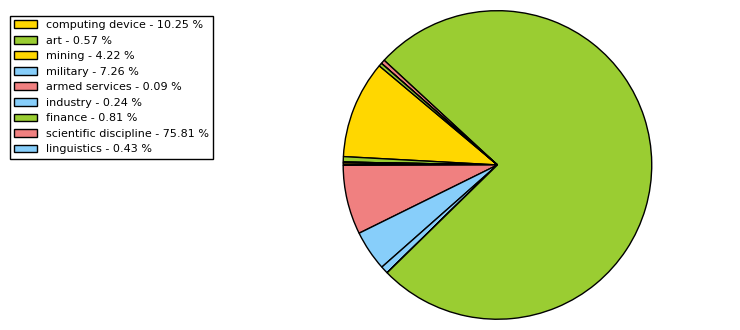

For Topic =  [2, 4]
Visualization based on Category frequency: 


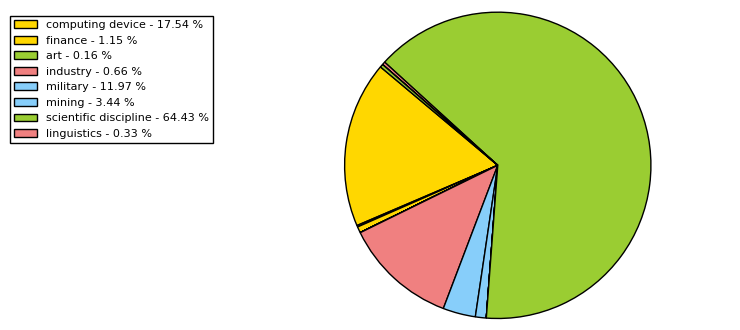

For Topic =  [5]
Visualization based on Category frequency: 


C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


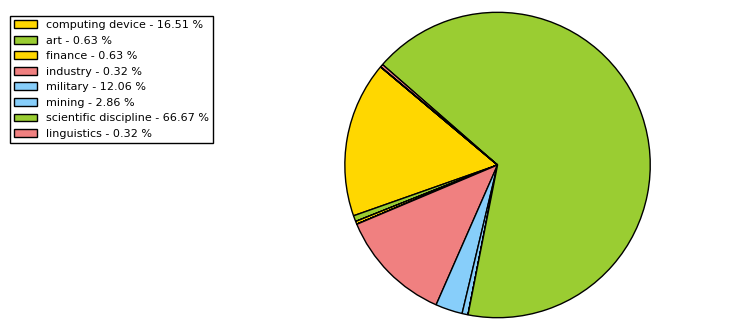

For Topic =  [6, 7, 8]
Visualization based on Category frequency: 


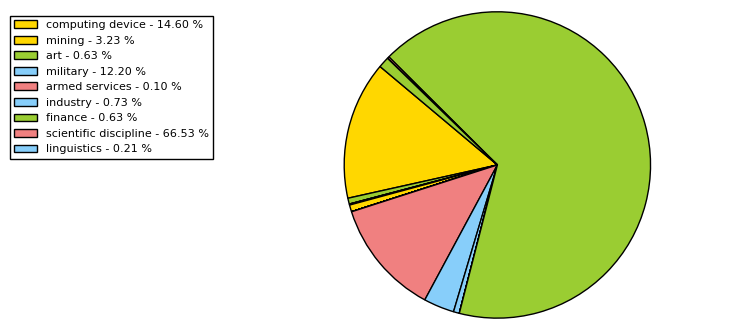

For Topic =  [9, 10]
Visualization based on Category frequency: 


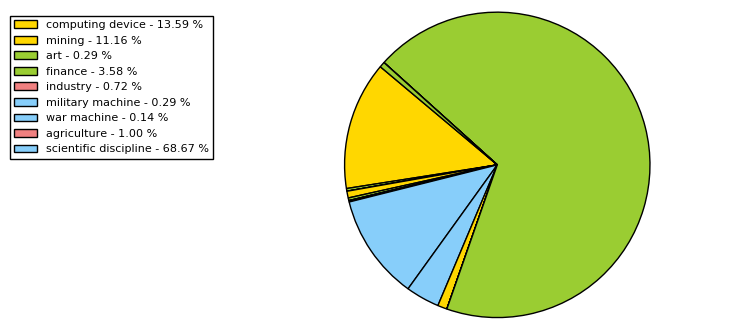

For month August
For Topic =  [1, 2, 8]
Visualization based on Category frequency: 


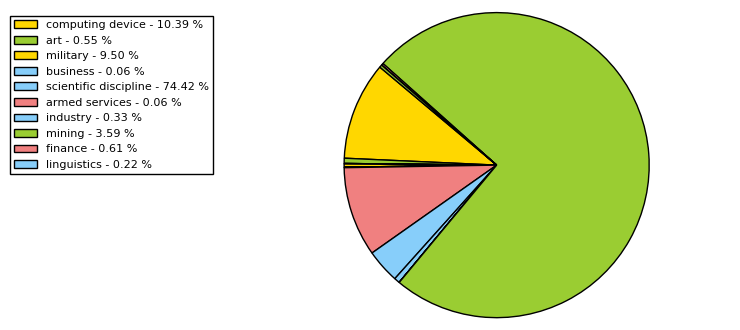

For Topic =  [3]
Visualization based on Category frequency: 


C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


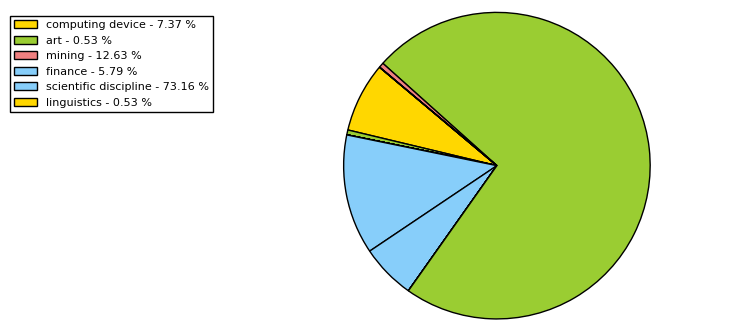

For Topic =  [4, 9]
Visualization based on Category frequency: 


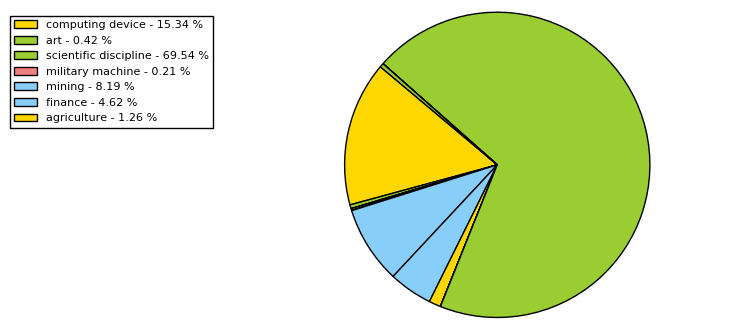

For Topic =  [5, 10]
Visualization based on Category frequency: 


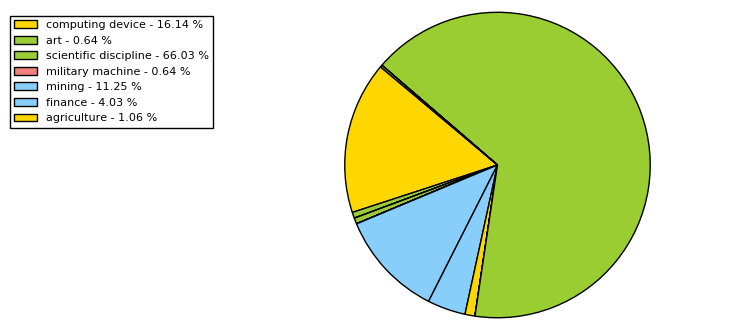

For Topic =  [6, 7]
Visualization based on Category frequency: 


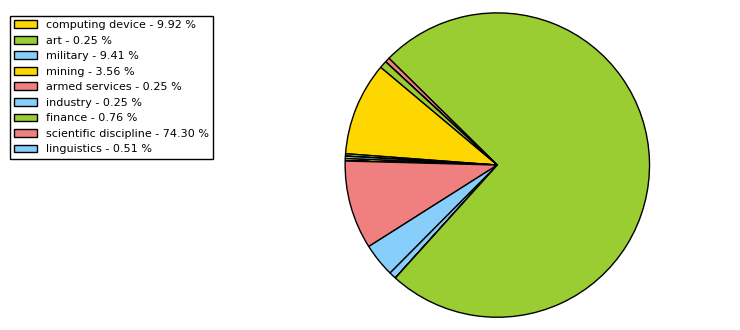

For month September
For Topic =  [1, 2]
Visualization based on Category frequency: 


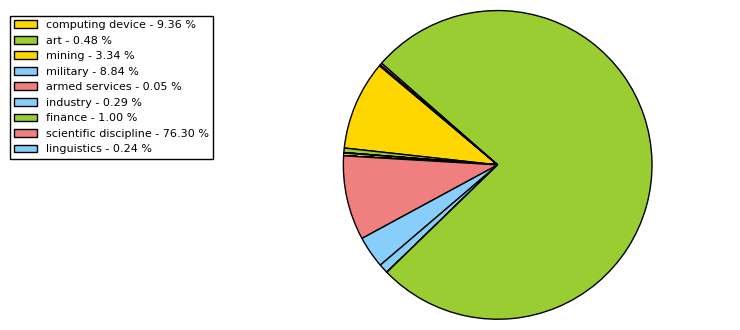

For Topic =  [3, 8]
Visualization based on Category frequency: 


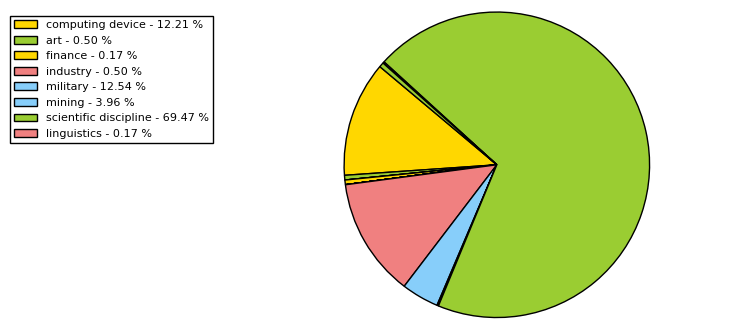

For Topic =  [4, 6]
Visualization based on Category frequency: 


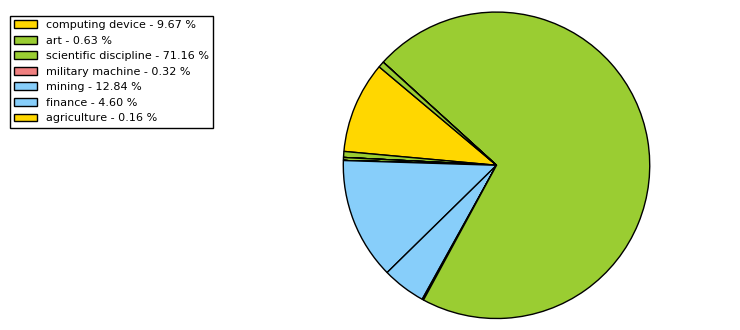

For Topic =  [5]
Visualization based on Category frequency: 


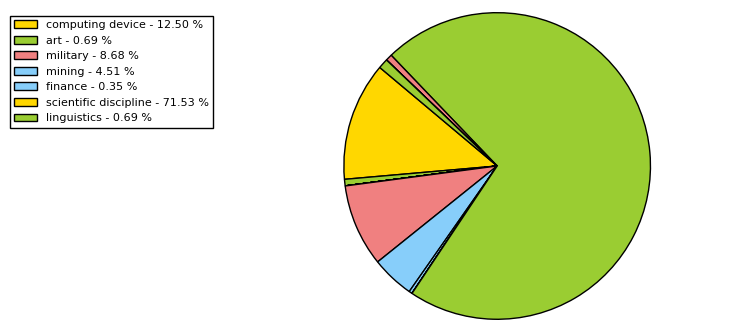

For Topic =  [7, 9, 10]
Visualization based on Category frequency: 


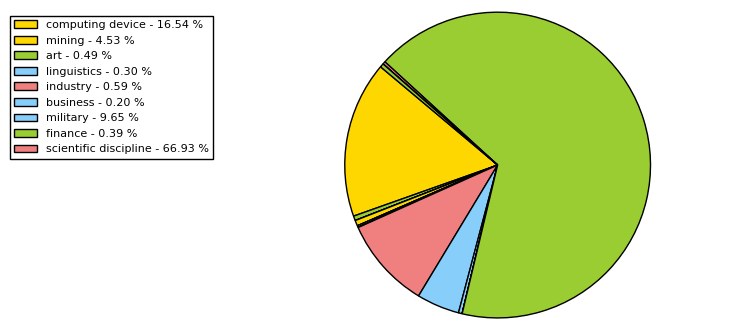

For month October
For Topic =  [1, 3]
Visualization based on Category frequency: 


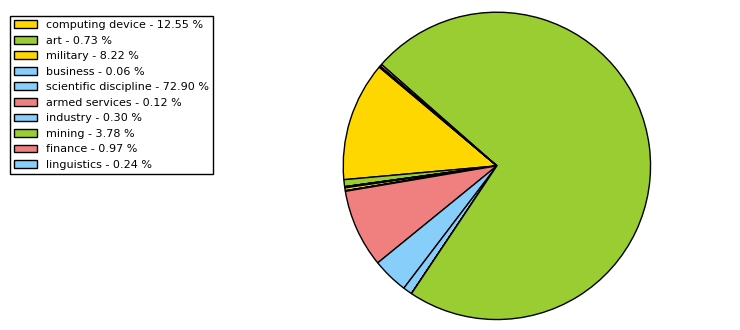

For Topic =  [2, 8]
Visualization based on Category frequency: 


C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


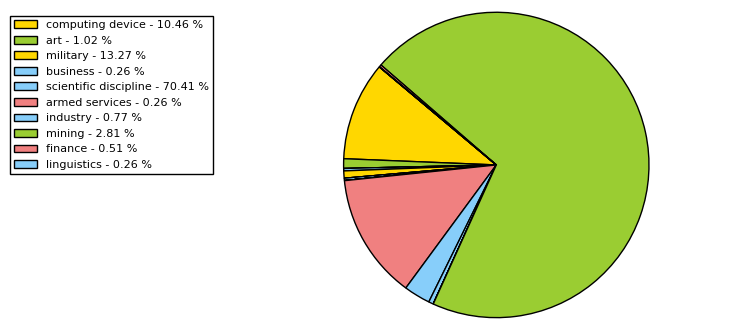

For Topic =  [4]
Visualization based on Category frequency: 


C:\Users\shilp\Anaconda3\lib\site-packages\ipykernel\__main__.py:16: DeprecationWarning: in the future out of bounds indices will raise an error instead of being ignored by `numpy.delete`.


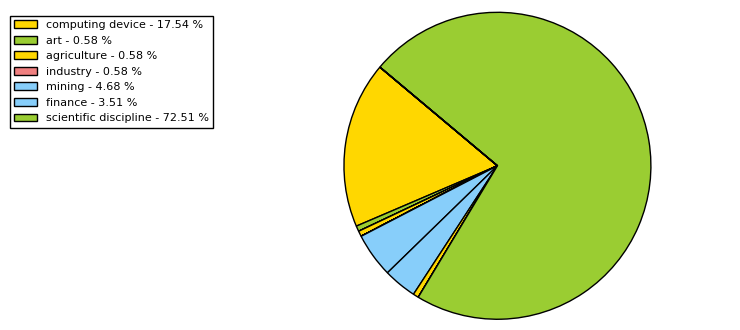

For Topic =  [5, 7, 10]
Visualization based on Category frequency: 


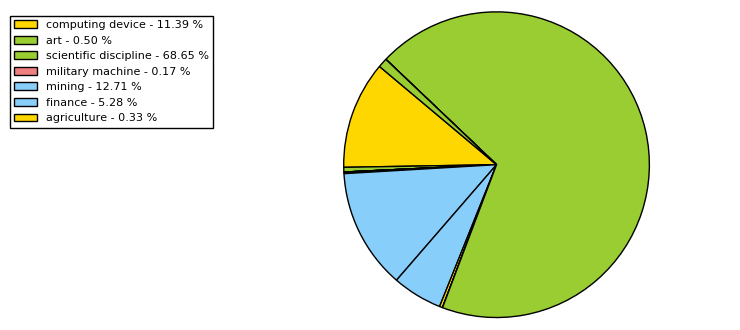

For Topic =  [6, 9]
Visualization based on Category frequency: 


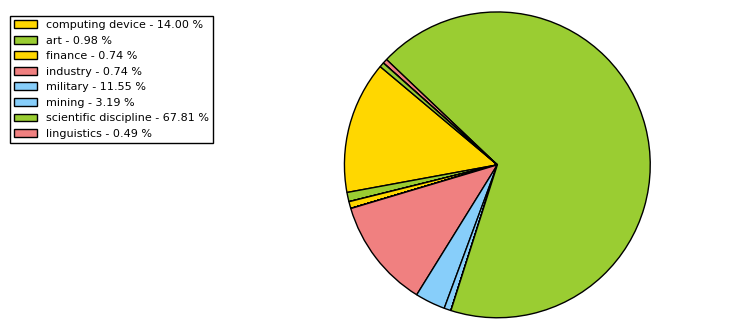

Done Visualising and saving pie charts...


In [13]:
#Creates a pie chart and saves it as a png file to be loaded later
fileNameTemplate = path+'\Plot{0:2s}'
categoryy_list=categories.keys()
categoryy_list=list(categoryy_list)
for month in date_list:
  print("For month",month)
  for itr,topic in enumerate(dict_topics_groups_m[month]): # e.g. 4 = [4,3,7,11]
#ss_visualize(topic,clusters[str(topic)],mse[str(topic)],seeds_score[str(topic)]) # Visualize the Semi-supervised categorization
     print('For Topic = ',topic)
     print('Visualization based on Category frequency: ', flush = True)
     y=np.array(list(topic_categories_freq[month][str(topic)].values()))
     percent = 100.*y/y.sum()
     indices=np.where(percent == 0)[0].tolist()
     porcent=np.delete(percent,indices)
     np.asarray(categoryy_list)
     category_list=np.delete(categoryy_list,indices).tolist()
     labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(category_list, porcent)]
     #labels = list(topic_categories_freq_c[country][str(topic)].keys())
     #print(labels)
     sizes = list(topic_categories_freq[month][str(topic)].values())
     colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','lightskyblue'][:len(labels)]
     explode = (0.1, 0, 0, 0)  # explode 1st slice: Change this anyway you like
     patches,text=plt.pie(sizes, colors=colors, startangle=140)
     plt.axis('equal')
     sort_legend = True
     if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))

     plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

     plt.savefig(fileNameTemplate.format(str(topic)+'-'+month+'.png'), format='png', bbox_inches='tight')
     plt.show()
print('Done Visualising and saving pie charts...')

In [ ]:
'''
#Creates a pie chart and saves it as a png file to be loaded later --> for countries
fileNameTemplate = path+'\Plot{0:2s}'
for country in country_list:
  print("For country",country)
  for itr,topic in enumerate(dict_topics_groups_c[country]): # e.g. 4 = [4,3,7,11]
#ss_visualize(topic,clusters[str(topic)],mse[str(topic)],seeds_score[str(topic)]) # Visualize the Semi-supervised categorization
     print('For Topic = ',topic)
     print('Visualization based on Category frequency: ', flush = True)
     y=np.array(list(topic_categories_freq_c[country][str(topic)].values()))
     percent = 100.*y/y.sum()
     indices=np.where(percent == 0)[0].tolist()
     porcent=np.delete(percent,indices)
     np.asarray(categoryy_list)
     category_list=np.delete(categoryy_list,indices).tolist()
     labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(category_list, porcent)]
     print(list(topic_categories_freq_c[country][str(topic)].values()))
     #labels = list(topic_categories_freq_c[country][str(topic)].keys())
     #print(labels)
     sizes = list(topic_categories_freq_c[country][str(topic)].values())
     colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue','lightskyblue'][:len(labels)]
     explode = (0.1, 0, 0, 0)  # explode 1st slice: Change this anyway you like
     patches,text=plt.pie(sizes, colors=colors, startangle=140)
     plt.axis('equal')
     sort_legend = True
     if sort_legend:
        patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))

     plt.legend(patches, labels, loc='left center', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)

     plt.savefig(fileNameTemplate.format(str(topic)+'-'+country+'.png'), format='png',bbox_inches='tight')
     plt.show()
print('Done Visualising and saving pie charts...')
'''

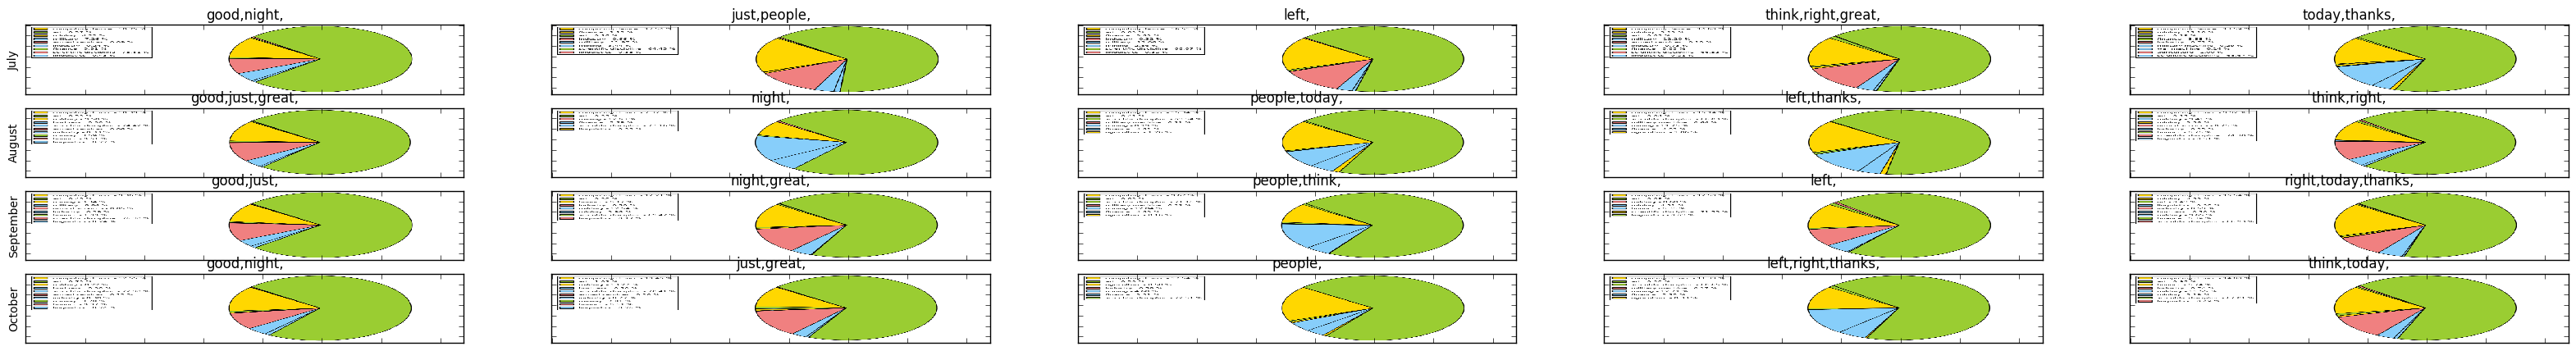

Done plotting for months...


In [14]:
#Loads back the saved png pie charts to be displayed over month-topic groups axes

n_clusters=5      #the one specified in kmm
fig, axarr = plt.subplots(nrows=len(date_list),ncols= n_clusters, sharex='col', sharey='row',  figsize=(40,5))
'''
file_list = glob.glob(path + '/*.png')
x = []
file_names=[]
y=[]
v=1
for file_path in file_list:
 head, tail = ntpath.split(file_path)
 x.append(tail.split('-',1)[0])
 file_names.append(tail.split('-',1)[1])
for file_name in file_names:
 y.append(file_name.split('.',1)[0])
print(y)
'''
#When there's a single month detected, use 1D array for co-ordinates
r=0
if len(date_list)==1:
    axarr[0].yaxis.set_label_position("left")
    axarr[0].set_ylabel(date_list[0])
    c=0
    for col in dict_topics_groups_m[date_list[0]]:
      ttl=''
      for top in col:
        ttl=ttl+mydict[str(top)]+','
      axarr[c].set_title(ttl)
      img=fileNameTemplate.format(str(col))+'-'+date_list[0]+'.png'
      o=axarr[c].imshow(mpimg.imread(img),interpolation='nearest', aspect='auto')
      plt.setp(axarr[c].get_xticklabels(), visible=False)
      plt.setp(axarr[c].get_yticklabels(), visible=False)
      c+=1
    
#else use numpy multi-dimesnional array
else:
 for row in date_list:
    c=0
    axarr[r,0].yaxis.set_label_position("left")
    axarr[r,0].set_ylabel(row)
    for col in dict_topics_groups_m[row]:  
      ttl=''
      for top in col:
        ttl=ttl+mydict[str(top)]+','
      #axarr[0,c].yaxis.set_label_position("top")
      axarr[r,c].set_title(ttl)
      img=fileNameTemplate.format(str(col))+'-'+row+'.png'
      #if os.path.isfile(img):
      #print("row");print(r);print("column"); print(c)
      o=axarr[r, c].imshow(mpimg.imread(img),interpolation='nearest',aspect='auto')
      plt.setp(axarr[r,c].get_xticklabels(), visible=False)
      plt.setp(axarr[r,c].get_yticklabels(), visible=False)
      c+=1
    r+=1
plt.show()
print("Done plotting for months...")

In [ ]:
'''
#Loads back the saved png pie charts to be displayed over month-topic groups axes

n_clusters=5      #the one specified in kmm
fig, axarr = plt.subplots(nrows=len(country_list),ncols= n_clusters, sharex='col', sharey='row',  figsize=(40,15))
'''
file_list = glob.glob(path + '/*.png')
x = []
file_names=[]
y=[]
v=1
for file_path in file_list:
 head, tail = ntpath.split(file_path)
 x.append(tail.split('-',1)[0])
 file_names.append(tail.split('-',1)[1])
for file_name in file_names:
 y.append(file_name.split('.',1)[0])
print(y)
'''
if len(country_list)==1:
    axarr[0].yaxis.set_label_position("left")
    axarr[0].set_ylabel(country_list[0])
    c=0
    for col in dict_topics_groups_c[country_list[0]]: 
      ttl=''
      for top in col:
        ttl=ttl+mydict_c[str(top)]+','
      axarr[c].set_title(ttl)
      img=fileNameTemplate.format(str(col))+'-'+country_list[0]+'.png'
      print(img)
      o=axarr[c].imshow(mpimg.imread(img),interpolation='nearest', aspect='auto')
      plt.setp(axarr[c].get_xticklabels(), visible=False)
      plt.setp(axarr[c].get_yticklabels(), visible=False)
      c+=1
else:
 r=0
 for row in country_list:
    c=0
    axarr[r,0].yaxis.set_label_position("left")
    axarr[r,0].set_ylabel(row)
    for col in dict_topics_groups_c[row]:  
      ttl=''
      for top in col:
        ttl=ttl+mydict_c[str(top)]+','
      #axarr[0,c].yaxis.set_label_position("top")
      axarr[r,c].set_title(ttl)
      img=fileNameTemplate.format(str(col))+'-'+row+'.png'
      #if os.path.isfile(img):
      #print("row");print(r);print("column"); print(c)
      o=axarr[r, c].imshow(mpimg.imread(img),interpolation='nearest', aspect='auto')
      plt.setp(axarr[r,c].get_xticklabels(), visible=False)
      plt.setp(axarr[r,c].get_yticklabels(), visible=False)
      c+=1
    r+=1
plt.show()
print("Done plotting for months...")
'''